# CIVE70011 Operational Research and Systems Analysis
### Majd Yousof
### CID: 02061161

To start running this file, it would be recommended to do so in a python `venv` environment, or any other environment management package of your choice. A `requirements.txt` file has been provided that contains the necessary dependencies, that can be installed into the activated environment using the following shell script:

```bash
pip install -r requirements.txt
```
Thank You!

In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Part 1: Exploratory Data analysis
In this section, the data and possible insights are extracted.

In [ ]:
# loading the dataset
data = pd.read_csv('cw_dataset.csv')
data.head()

,id,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,1,"2 BHK Flat for Rent in Oberoi Woods, Goregaon ...",Goregaon East,Mumbai,897,2,2,0,Semi-Furnished,134.0,120000.0
1,2,"1 BHK Flat for Rent in Sapphire Lakeside, Powa...",Powai,Mumbai,490,1,1,0,Semi-Furnished,82.0,40000.0
2,3,1 BHK House for Rent in Mundhwa Pune,Mundhwa,Pune,550,1,1,0,Unfurnished,22.0,12000.0
3,4,"2 BHK Flat for Rent in Hingna, Nagpur",Hingna,Nagpur,1000,2,2,0,Unfurnished,8.0,8000.0
4,5,1 BHK Flat for Rent in Unique Star Harsh Vihar...,Mira Road,Mumbai,595,1,1,0,Unfurnished,25.0,15000.0


## Question 1: 
Calculate the mean, standard deviation, and percentiles for each of the numerical features in the dataset, then Calculate the number of apartments at each city and plot the average rent price in each city.

In [ ]:
# calculating the means, standard deviations, and percentiles of the area, beds, bathrooms, balconies, area_rate, and rent columns
descriptions = data[['area', 'beds', 'bathrooms', 'balconies', 'area_rate', 'rent']].describe()
descriptions

,area,beds,bathrooms,balconies,area_rate,rent
count,7691.000000,7691.000000,7691.000000,7691.000000,7691.000000,7.691000e+03
mean,1106.354180,2.208685,2.137043,0.817319,47.619989,5.479508e+04
std,1197.426843,0.993481,1.027677,1.243361,68.989657,9.742006e+04
min,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000e+03
25%,600.000000,1.000000,1.000000,0.000000,21.000000,1.500000e+04
50%,900.000000,2.000000,2.000000,0.000000,31.000000,2.800000e+04
75%,1300.000000,3.000000,3.000000,2.000000,54.000000,5.700000e+04
max,70000.000000,10.000000,10.000000,10.000000,2586.000000,2.700000e+06


### A few things that can be noticed from the `descriptions` dataframe:
 
The mean `rent`,`balconies`,`area_rate` and `area` are significantly higher than their respective medians; can either indicate that the rent distribution is positively skewed, or that the data contains a few outliers that affect the calculation of the mean.

In [20]:
# calculating the number of apartments in each city
cityApartmentCount = data['city'].value_counts()

# calculating the mean rent for each city
cityMeanRent = data.groupby('city')['rent'].mean()

citystats = pd.DataFrame({'count': cityApartmentCount, 'meanRent': cityMeanRent})
citystats

,count,meanRent
city,,
Bangalore,1790,56709.260894
Mumbai,1719,103226.538104
Nagpur,595,18015.784874
New Delhi,1808,41309.158739
Pune,1779,32077.928612


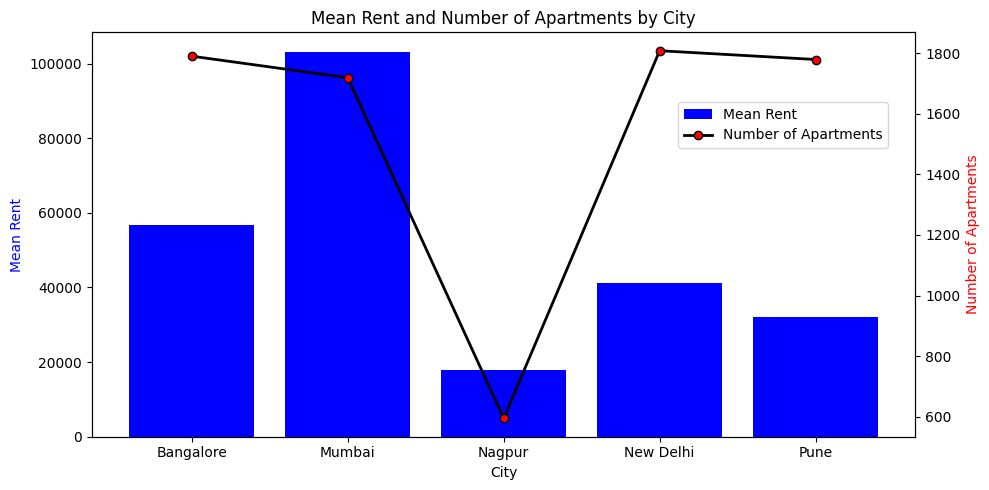

In [ ]:
## plotting the mean rent by city, with the number of apartments in each city as a secondary y-axis
fig, ax = plt.subplots(figsize=(10, 5))

# Mean rent by city
ax.bar(citystats.index, citystats['meanRent'], color='blue', label='Mean Rent')
ax.set_ylabel('Mean Rent', color='blue')
ax.set_xlabel('City')
ax.set_title('Mean Rent and Number of Apartments by City')

# Number of apartments by city
ax2 = ax.twinx()
ax2.plot(citystats.index, citystats['count'], color='black', marker='o', mec='black', mfc='red', linewidth=2, label='Number of Apartments')
ax2.set_ylabel('Number of Apartments', color='red')

# Adding the legend
fig.legend(['Mean Rent','Number of Apartments'], loc='upper right', bbox_to_anchor=(0.9, 0.8))

# plotting
plt.tight_layout()
plt.savefig('plots/rawMeanRent.svg')
plt.show()


## Question 2:
Removal of outliers and analysing data again.

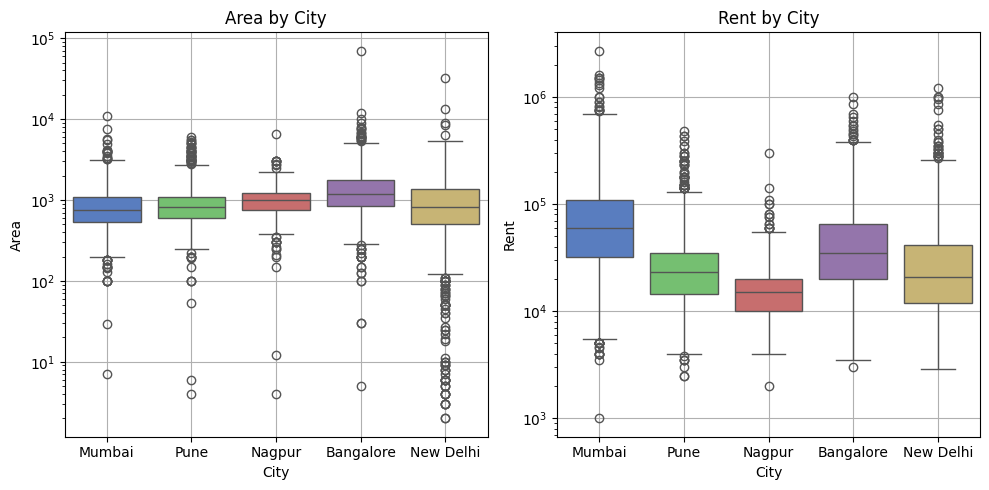

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plotting the boxplot of the area by city
sns.boxplot(data=data, x= 'city', y= 'area', ax=axs[0],log_scale=True, palette='muted6', hue='city')
axs[0].set_title('Area by City')
axs[0].set_ylabel('Area')
axs[0].set_xlabel('City')
axs[0].grid(True)

# plotting the boxplot of the rent by city
sns.boxplot(data=data, x= 'city', y= 'rent', ax=axs[1],log_scale=True, palette='muted6', hue='city')
axs[1].set_title('Rent by City')
axs[1].set_ylabel('Rent')
axs[1].set_xlabel('City')
axs[1].grid(True)

plt.tight_layout()
plt.savefig('plots/compBoxPlot.svg')
plt.show()

These boxplots indicate that there are indeed many outliers within the dataset, however, removing all the outliers that lie beyond the quantiles of the dataset may not be the best option, as there is a significant amount which may affect the representative accuracy of the dataset. It would be wise to compare area and rent prices per city (as done below), to capture more information about the outliers.

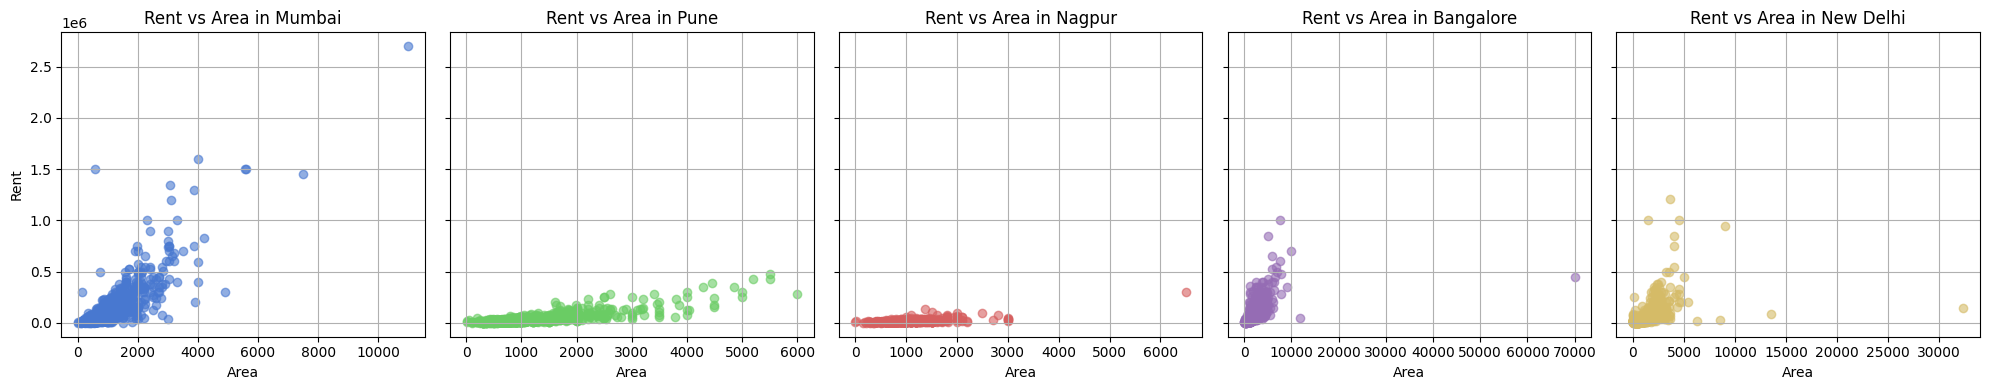

In [89]:
# Get unique cities
cities = data['city'].unique()

# Create a figure and subplots with a grid of 1 row and len(cities) columns
fig, axs = plt.subplots(1, len(cities), figsize=(20, 4), sharey=True)

# Loop through each city and create a scatter plot for each
for i, city in enumerate(cities):
    city_data = data[data['city'] == city]  # Filter data by city
    axs[i].scatter(city_data['area'], city_data['rent'], color= sns.color_palette('muted6')[i], alpha=0.6, marker='o')
    axs[i].set_title(f'Rent vs Area in {city}')
    axs[i].grid(True)
    axs[i].set_xlabel('Area')
    if i == 0:
        axs[i].set_ylabel('Rent')
    
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('plots/compRentVsArea.svg')
plt.show()

For the Rent vs Area, it is clear that there are a few trends that are visible. It is also true that the visual outliers appear to be far fewer than before, so this plot will be mainly used to determine outliers. For this dataset, the outliers for each city lie **beyond**:\
- ***Mumbai:*** Area = 5000 or Rent = 1,500,000
- ***Pune:*** Area = 5500
- ***Nagpur:***